In [1]:
from google.colab import drive
import pickle
drive.mount("/content/drive", force_remount=True)

with open('/content/drive/MyDrive/Projet non-alternant/Vidéo/test/test2.pkl', "rb") as f:
    X_test, y_test = pickle.load(f)

Mounted at /content/drive


In [ ]:
print(len(X_test))

868


✅ Modèle chargé depuis : /content/drive/MyDrive/Projet non-alternant/Vidéo/best_mvitv2.pth


Évaluation du modèle: 100%|██████████| 109/109 [01:14<00:00,  1.47it/s]



🎯 Résultats sur le test :
   🔸 Test Accuracy : 0.5276
   🔸 Test Loss     : 1.7081


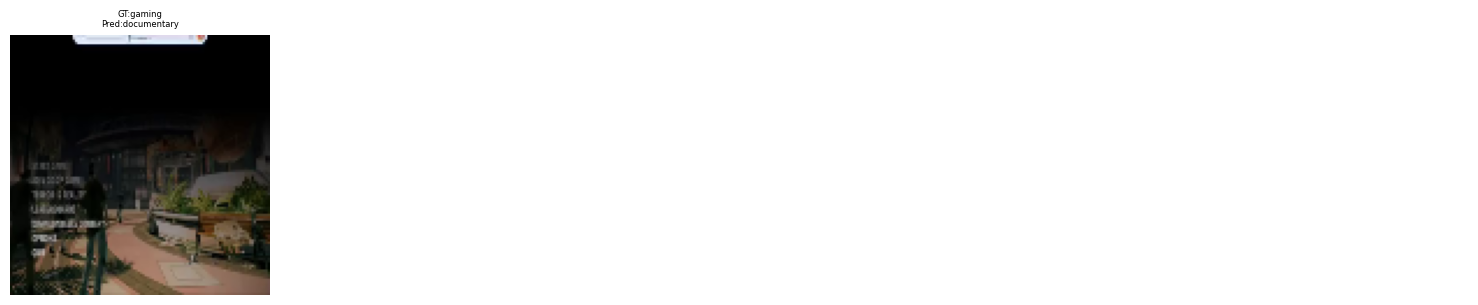

In [2]:
# ============================================================
# ⚙️ INSTALLATION ET IMPORTS
# ============================================================
!pip install torch torchvision tqdm -q

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from tqdm import tqdm
import cv2, numpy as np, pickle
import matplotlib.pyplot as plt
from google.colab import drive



# ============================================================
# 3️⃣ TRANSFORMATIONS
# ============================================================
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),  # pour MViTv2
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.43216, 0.394666, 0.37645],
                         std=[0.22803, 0.22145, 0.216989]),
])

# ============================================================
# 4️⃣ DATASET DE TEST
# ============================================================
class TestDataset(Dataset):
    def __init__(self, videos, labels, transform=None, target_frames=16):
        self.videos = videos
        self.labels = labels
        self.transform = transform
        self.target_frames = target_frames

    def __len__(self):
        return len(self.videos)

    def __getitem__(self, idx):
        frames = [cv2.cvtColor(f, cv2.COLOR_BGR2RGB) for f in self.videos[idx]]

        if len(frames) < self.target_frames:
            repeat_factor = int(np.ceil(self.target_frames / len(frames)))
            frames = (frames * repeat_factor)[:self.target_frames]
        else:
            frames = frames[:self.target_frames]

        if self.transform:
            frames = [self.transform(f) for f in frames]

        video_tensor = torch.stack(frames, dim=1)  # (C, T, H, W)
        return video_tensor, torch.tensor(self.labels[idx], dtype=torch.long)

test_dataset = TestDataset(X_test, y_test, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=2)

# ============================================================
# 5️⃣ MODÈLE MViTv2 CUSTOM
# ============================================================
class MViTv2Custom(nn.Module):
    def __init__(self, num_classes=20, dropout_p=0.3, pretrained=False):
        super().__init__()
        weights = models.video.MViT_V2_S_Weights.KINETICS400_V1 if pretrained else None
        self.backbone = models.video.mvit_v2_s(weights=weights)
        in_features = self.backbone.head[1].in_features
        self.backbone.head[1] = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_p),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.backbone(x)

# ============================================================
# 6️⃣ CHARGEMENT DU MODELE ENTRAÎNÉ
# ============================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_path = "/content/drive/MyDrive/Projet non-alternant/Vidéo/best_mvitv2.pth"
model = MViTv2Custom(num_classes=20).to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()
print("✅ Modèle chargé depuis :", model_path)

# ============================================================
# 7️⃣ ÉVALUATION
# ============================================================
criterion = nn.CrossEntropyLoss()
running_test_loss = 0.0
correct, total = 0, 0
all_preds, all_labels = [], []

with torch.no_grad():
    for videos, labels in tqdm(test_loader, desc="Évaluation du modèle"):
        videos, labels = videos.to(device), labels.to(device)
        outputs = model(videos)
        loss = criterion(outputs, labels)
        running_test_loss += loss.item()

        preds = outputs.argmax(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_loss = running_test_loss / len(test_loader)
test_acc = correct / total

print(f"\n🎯 Résultats sur le test :")
print(f"   🔸 Test Accuracy : {test_acc:.4f}")
print(f"   🔸 Test Loss     : {test_loss:.4f}")

# ============================================================
# 8️⃣ AFFICHAGE DES PRÉDICTIONS
# ============================================================
class_names = {
    0: "music", 1: "people", 2: "gaming", 3: "sports/actions", 4: "news/events/politics",
    5: "education", 6: "tv shows", 7: "movie/comedy", 8: "animation", 9: "vehicles/autos",
    10: "howto", 11: "travel", 12: "science/technology", 13: "animals/pets", 14: "kids/family",
    15: "documentary", 16: "food/drink", 17: "cooking", 18: "beauty/fashion", 19: "advertisement"
}

n = min(1, len(all_preds))
cols = 5
rows = int(np.ceil(n / cols))
fig, axes = plt.subplots(rows, cols, figsize=(cols*3, rows*3))
axes = axes.flatten()

for i in range(n):
    frame = X_test[i][0]
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    real_name = class_names[all_labels[i]]
    pred_name = class_names[all_preds[i]]
    axes[i].imshow(frame_rgb)
    axes[i].axis("off")
    axes[i].set_title(f"GT:{real_name}\nPred:{pred_name}", fontsize=6)

for j in range(n, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.savefig("/content/drive/MyDrive/Projet non-alternant/Vidéo/test/predictions_best_mvitv2.pdf")
plt.show()


In [ ]:
import pandas as pd
import torch.nn.functional as F

# Charger le CSV filtré avec les noms de vidéos
df_images_filtered = pd.read_csv("drive/MyDrive/Projet non-alternant/Vidéo/test/video_names_unique2.csv")
video_names = df_images_filtered["video_name"].tolist()

# ============================================================
# ÉVALUATION + RÉCUPÉRATION DES PROBAS
# ============================================================
criterion = nn.CrossEntropyLoss()
running_test_loss = 0.0
correct, total = 0, 0
all_preds, all_labels, all_probs = [], [], []

with torch.no_grad():
    for videos, labels in tqdm(test_loader, desc="Évaluation du modèle"):
        videos, labels = videos.to(device), labels.to(device)
        outputs = model(videos)
        loss = criterion(outputs, labels)
        running_test_loss += loss.item()

        probs = F.softmax(outputs, dim=1)  # 🔹 convertir les logits en probabilités
        preds = torch.argmax(probs, dim=1)

        correct += (preds == labels).sum().item()
        total += labels.size(0)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())



proba_df = pd.DataFrame(all_probs, columns=[class_names[i] for i in range(len(class_names))])
proba_df["true_label"] = [class_names[y] for y in all_labels]
proba_df["pred_label"] = [class_names[y] for y in all_preds]
proba_df["video_name"] = video_names  # Ajouter la colonne video_name

# Sauvegarder en CSV
output_path = "/content/drive/MyDrive/Projet non-alternant/Vidéo/test/test_predictions_video2.csv"
proba_df.to_csv(output_path, index=False)

print(f"✅ Fichier des probabilités avec video_name sauvegardé : {output_path}")


Évaluation du modèle: 100%|██████████| 109/109 [01:12<00:00,  1.49it/s]

✅ Fichier des probabilités avec video_name sauvegardé : /content/drive/MyDrive/Projet non-alternant/Vidéo/test/test_predictions_video2.csv


In [ ]:
import pandas as pd

# chemins vers les fichiers
file1 = "/content/drive/MyDrive/Projet non-alternant/Vidéo/test/test_predictions_video.csv"
file2 = "/content/drive/MyDrive/Projet non-alternant/Vidéo/test/test_predictions_video2.csv"

# charger le second fichier et enlever la première ligne
df2 = pd.read_csv(file2, skiprows=1, header=None)

# charger le premier fichier normalement
df1 = pd.read_csv(file1)

# concaténer les deux
df_concat = pd.concat([df1, df2], ignore_index=True)

# sauvegarder le résultat (écrase le premier fichier)
df_concat.to_csv(file1, index=False)

print("Concaténation terminée ! Le fichier a été mis à jour.")


Concaténation terminée ! Le fichier a été mis à jour.


In [ ]:
plt.savefig("/content/drive/MyDrive/Projet non-alternant/Vidéo/test/predictions.pdf")

<Figure size 640x480 with 0 Axes>

/tmp/ipython-input-1956960922.py:26: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


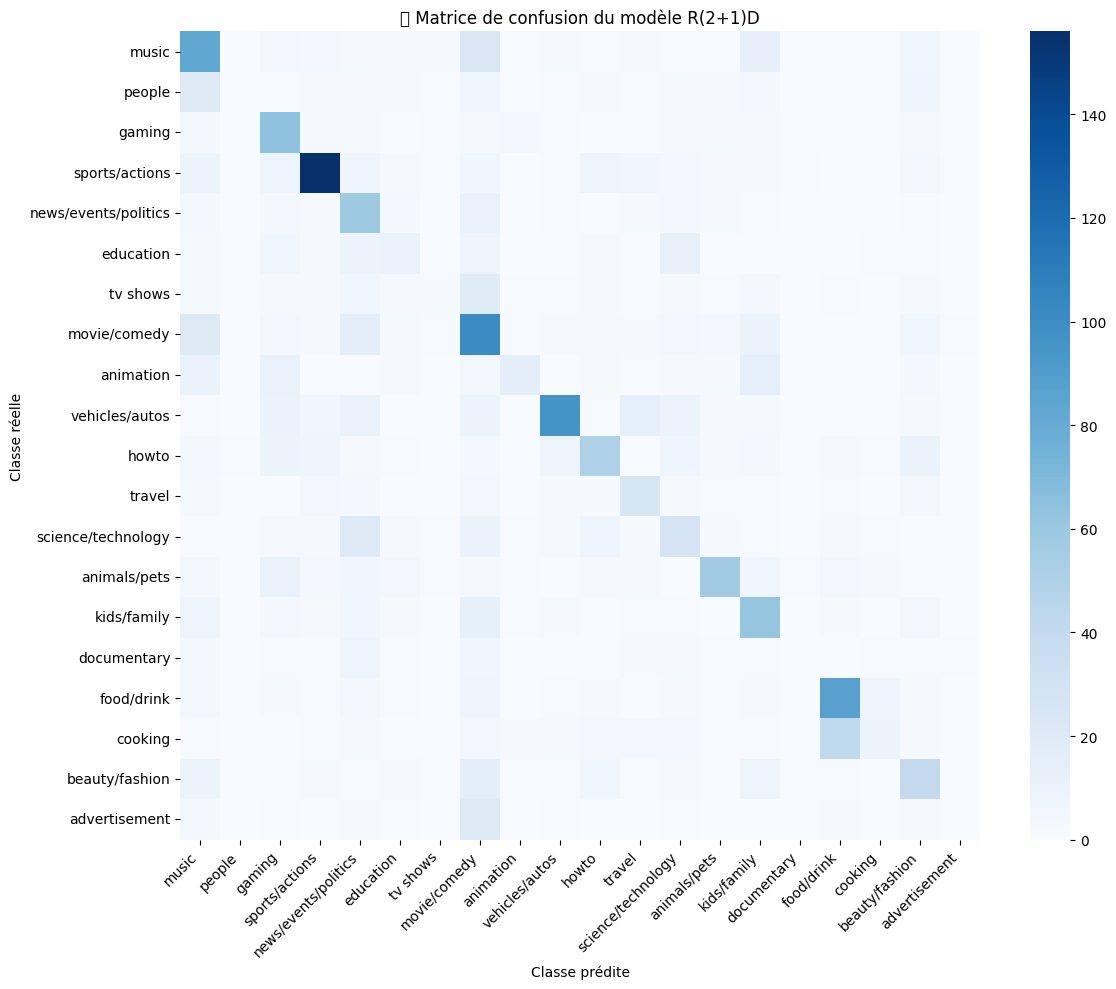


📋 Rapport de classification :

                      precision    recall  f1-score   support

               music       0.42      0.54      0.47       154
              people       0.00      0.00      0.00        52
              gaming       0.44      0.69      0.53        93
      sports/actions       0.76      0.71      0.73       220
news/events/politics       0.34      0.60      0.44        98
           education       0.24      0.20      0.22        55
            tv shows       0.27      0.05      0.09        55
        movie/comedy       0.36      0.55      0.43       183
           animation       0.55      0.22      0.32        72
      vehicles/autos       0.74      0.58      0.65       166
               howto       0.52      0.43      0.47       115
              travel       0.36      0.44      0.39        57
  science/technology       0.29      0.31      0.30        89
        animals/pets       0.65      0.51      0.57       111
         kids/family       0.44      

In [ ]:
# ============================================================
# 🔹 12. MATRICE DE CONFUSION
# ============================================================
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

# Calcul de la matrice de confusion
cm = confusion_matrix(all_labels, all_preds)
num_classes = len(class_names)

# Affichage avec seaborn
plt.figure(figsize=(12, 10))
sns.heatmap(
    cm,
    annot=False,          # Mets True si tu veux les valeurs dans les cases
    fmt="d",
    cmap="Blues",
    xticklabels=[class_names[i] for i in range(num_classes)],
    yticklabels=[class_names[i] for i in range(num_classes)]
)
plt.title("📉 Matrice de confusion du modèle R(2+1)D")
plt.xlabel("Classe prédite")
plt.ylabel("Classe réelle")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# ============================================================
# 🔹 13. (Optionnel) Rapport de classification
# ============================================================
from sklearn.metrics import classification_report

print("\n📋 Rapport de classification :\n")
print(classification_report(all_labels, all_preds, target_names=[class_names[i] for i in range(num_classes)]))
